In [114]:
from __future__ import print_function
print(__doc__)

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from grakel.datasets import fetch_dataset
from grakel.datasets import get_dataset_info
from grakel.kernels import ShortestPath

import networkx as nx

import pickle

Automatically created module for IPython interactive environment


## PTC-FM 
https://paperswithcode.com/dataset/ptc

In [103]:
#@title Helper functions for plotting
def plot_graphs(axs, idices, graphs):
    n_plots = len(idices)
    for i, idx in enumerate(idices):
        ax = axs[i]
        G = graphs[idx]
        nx.draw(G, with_labels=True, ax=ax, pos=nx.spring_layout(G))
        ax.set_title("Graph {}".format(idx))

def plot_adj_mats(axs, adj_mats, indices):
    for i, idx in enumerate(indices):
        ax = axs[i]
        B = adj_mats[idx]
        ax.imshow(B)
        ax.set_title("Graph {}".format(idx))

In [3]:
# Loads the PTC dataset
PTC = fetch_dataset("PTC_FM", verbose=False)
get_dataset_info("PTC_FM")

{'nl': True,
 'el': True,
 'na': False,
 'ea': False,
 'link': 'https://ls11-www.cs.uni-dortmund.de/people/morris/graphkerneldatasets/PTC_FM.zip'}

In [54]:
# checkout the data
ds, y = PTC.data, PTC.target
for i in range(1):
    print(ds[i])#data
    print(y[i]) #prediction outcomes
print(y[:10])


[{(1, 2), (2, 1)}, {1: 0, 2: 1}, {(2, 1): 0, (1, 2): 0}]
1
[ 1  1 -1  1 -1 -1  1  1  1 -1]


### full dataset

In [49]:
data_pos = [np.array([list(i) for i in data[0]]) for data in ds] # extract edges
n_nodes = [len(np.unique(edges)) for edges in data_pos] # extract number of nodes
adj_mats_zeros = [np.zeros((n, n), dtype=np.int64) for n in n_nodes] # create zero adjacency matrices

In [50]:
adj_mats = []
for adj_mat, edges in zip(adj_mats_zeros, data_pos):
    edges_shifted = edges - np.min(edges) # -min(edges) to make it 0-indexed
    # print(edges_shifted)
    for edge in edges_shifted:
        adj_mat[int(edge[0]), int(edge[1])] = 1.
    adj_mats.append(adj_mat)
        

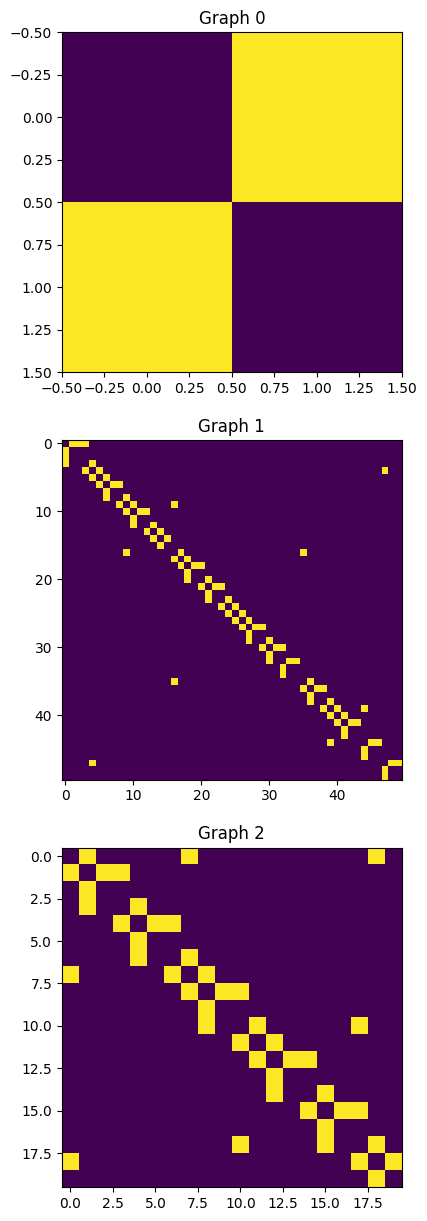

In [104]:
#@title visualizing the graph using adjacency matrix representation
n_plots = 3
fig, axs = plt.subplots(n_plots, 1, figsize=(6, 5 * n_plots))

plot_adj_mats(axs, adj_mats, range(n_plots))

Text(0, 0.5, 'count')

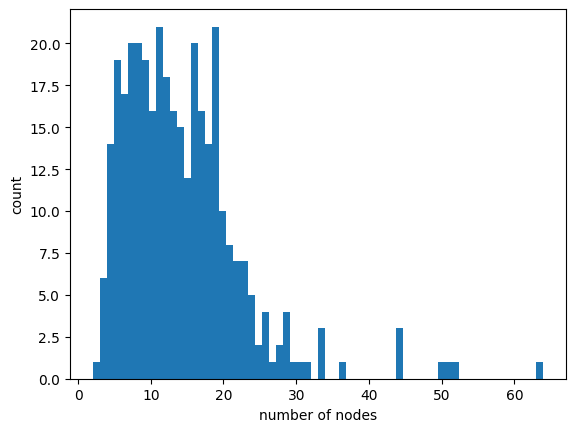

In [56]:
plt.hist(n_nodes, bins=64) # plot the total numbers of nodes in graphs
plt.xlabel("number of nodes")
plt.ylabel("count")

In [80]:
#@title construct graph from adjacency matrix
graphs = []
for adj_mat in adj_mats:
    graphs.append(nx.from_numpy_array(adj_mat))

In [89]:
# If you want to access the edges, you can do this
for i in range(3):
    print(graphs[i].edges())

[(0, 1)]
[(0, 1), (0, 2), (0, 3), (3, 4), (4, 5), (4, 47), (5, 6), (6, 7), (6, 8), (8, 9), (9, 10), (9, 16), (10, 11), (10, 12), (12, 13), (13, 14), (14, 15), (16, 17), (16, 35), (17, 18), (18, 19), (18, 20), (20, 21), (21, 22), (21, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (27, 29), (29, 30), (30, 31), (30, 32), (32, 33), (32, 34), (35, 36), (36, 37), (36, 38), (38, 39), (39, 40), (39, 44), (40, 41), (41, 42), (41, 43), (44, 45), (44, 46), (47, 48), (47, 49)]
[(0, 1), (0, 7), (0, 18), (1, 2), (1, 3), (3, 4), (4, 5), (4, 6), (6, 7), (7, 8), (8, 9), (8, 10), (10, 11), (10, 17), (11, 12), (12, 13), (12, 14), (14, 15), (15, 16), (15, 17), (17, 18), (18, 19)]


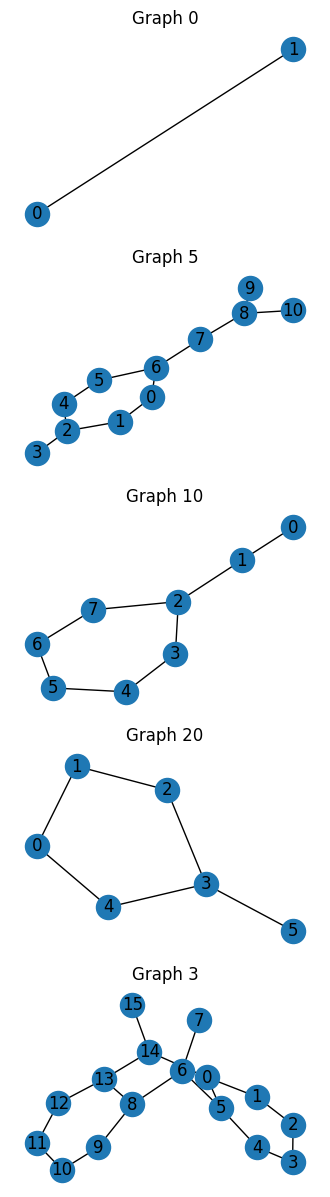

In [101]:
#@title Plot graphs 
idices = [0, 5, 10, 20, 3]
fig, axs = plt.subplots(n_plots, 1, figsize=(4, 3 * n_plots))        
plot_graphs(axs, idices, graphs)        

In [85]:
#@title finding the Fruchterman-Reingold layout
# note this is to find the layout of the graph so that 
# the nodes are placed in a way that maximize the distance between nodes
# that are not connected and minimize the distance between nodes that are connected by edges
graphs_pos = []
for graph in graphs:
    pos = nx.spring_layout(graph, )
    graphs_pos.append(pos)

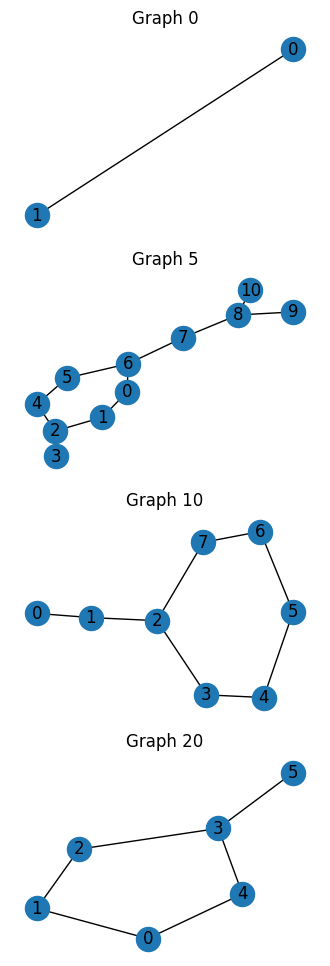

In [99]:
#@title Plot graphs with Fruchterman-Reingold layout
idices = [0, 5, 10, 20]
n_plots = len(idices)
fig, axs = plt.subplots(n_plots, 1, figsize=(4, 3 * n_plots))
for i, idx in enumerate(idices):
    ax = axs[i]
    G = graphs[idx]
    nx.draw(G, with_labels=True, pos=graphs_pos[idx], ax=ax)
    ax.set_title("Graph {}".format(idx))

### Restrict the size of the dataset

In [118]:
n_cut_off = 20 # cut off the graphs with more than 12 nodes
n_nodes_cut =  []
graphs_cut_off = []
graphs_pos_cut_off = []
for graph in graphs:
    if len(graph.nodes()) <= n_cut_off:
        n_nodes_cut.append(len(graph.nodes())) # append the number of nodes in small graphs
        graphs_cut_off.append(graph) # append small graphs
        graphs_pos_cut_off.append(nx.spring_layout(graph)) # append the layout of small graphs


In [119]:
# save the graphs with pickle
filename = f"PTC_graphs_max_{n_cut_off}_nodes.p"
pickle.dump(graphs_cut_off, open("Datasets/"+filename, "wb"))

In [113]:
# If you want to access the edges, you can do this
for i in range(3):
    print(graphs_cut_off[i].edges())

[(0, 1)]
[(0, 1), (0, 2), (2, 3), (2, 4)]
[(0, 1), (0, 6), (1, 2), (2, 3), (2, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (8, 10)]


Text(0.5, 1.0, 'total number of graphs is 171')

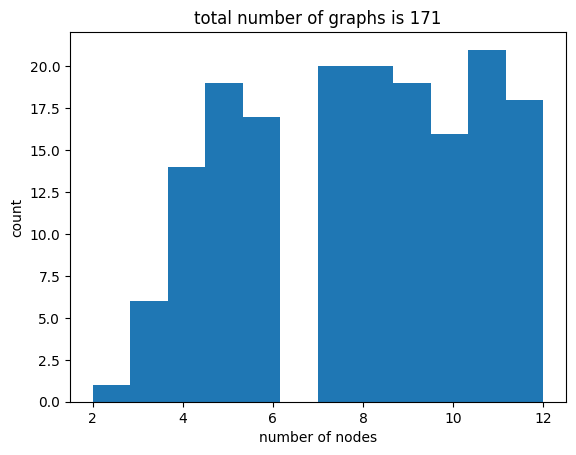

In [109]:
plt.hist(n_nodes_cut, bins=12) # plot the total numbers of nodes in graphs
plt.xlabel("number of nodes")
plt.ylabel("count")
plt.title(f"total number of graphs is {len(graphs_cut_off)}")

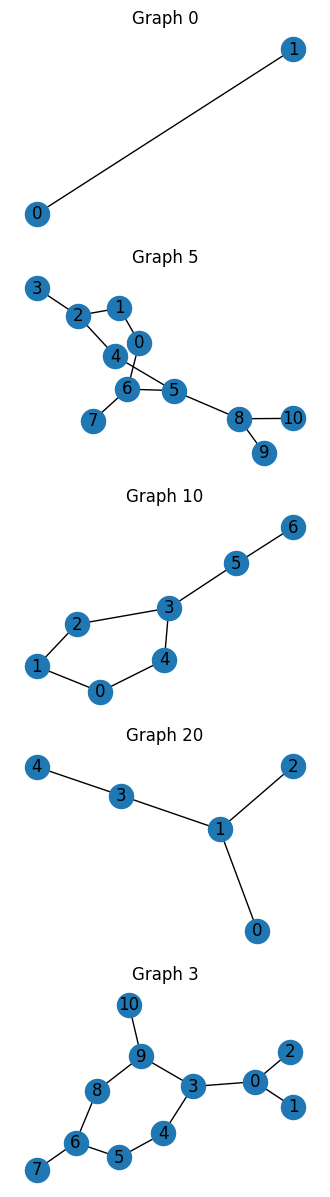

In [112]:
#@title Plot graphs 
idices = [0, 5, 10, 20, 3]
fig, axs = plt.subplots(len(idices), 1, figsize=(4, 3 * len(idices)))        
plot_graphs(axs, idices, graphs_cut_off)        

## Old code

In [ ]:
# Construct graph specifications from geometric nodes
graphs_pos = []
graphs_geometric = []
for graph_nodes in data_pos:
    pos = dict(zip(range(len(graph_nodes)), graph_nodes))
    geometric = [(i, dict(zip(['pos'], [pos[i]]))) for i in range(len(graph_nodes))]
    graphs_pos.append(pos)
    graphs_geometric.append(geometric)

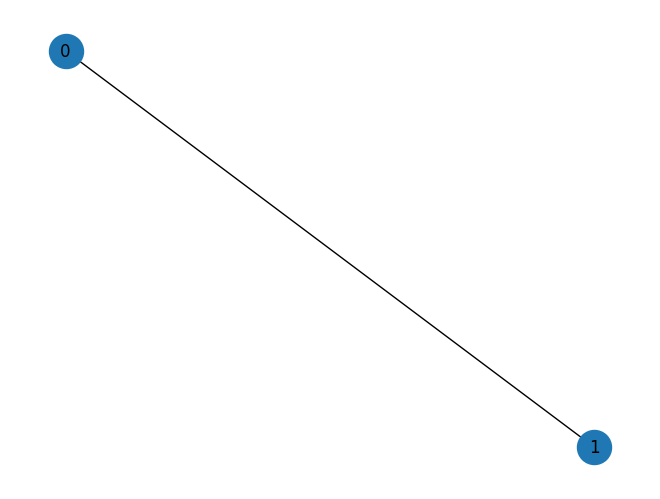

In [ ]:
#@title Construct graph from geometric nodes
idx = 0
G = nx.Graph()
G.add_nodes_from(graphs_geometric[idx])
# nx.geometric_edges(G, radius=1)

for edge in nx.geometric_edges(G, radius=2.1):
    # print(edge)
    G.add_edge(*edge)
nx.draw(G, with_labels=True, pos=graphs_pos[idx], node_size=600)    